In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hyperopt import hp
from fedot_ind.core.architecture.pipelines.abstract_pipeline import AbstractPipeline, ApiTemplate

In [2]:
def plot_mean_sample(X,y, labels:list = [], n_channel: int = 1):
    mean_sample = []
    if len(labels) == 0:
        labels = list(np.unique(y))
    for label in labels:
        mean_sample.append(np.mean(X[y == label] , axis=0)) # Данные класса 1
    #ax = plt.gca()
    channels = [f'Channel {x}' for x in range(n_channel)]
    df = pd.DataFrame(mean_sample).T
    df.columns = labels
    df.plot(kind ='line',subplots=True, layout=(1,len(labels)),figsize=(20,10))
    plt.legend(fontsize='small')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [3]:
def plot_mean_sample_multi(X,y, labels:list = [], n_channel: int = None):
    mean_sample = {}
    if len(labels) == 0:
        labels = list(np.unique(y))
    if n_channel is None:
        n_channel = X.shape[1]
    channels = [f'Channel {x}' for x in range(n_channel)]
    for label in labels:
        mask = y == label
        for chn in range(n_channel):
            mean_sample.update({f'Label_{label}_channel_{chn}':np.mean(X[mask.flatten(),chn,:] , axis=0)}) # Данные класса 1
    #ax = plt.gca()
    df = pd.DataFrame(mean_sample)
    df.plot(kind ='line')
    plt.suptitle('Усреднённые семплы по классам')
    plt.legend(fontsize='small')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [4]:
finetune = False
metric_names = ('f1', 'accuracy', 'precision', 'roc_auc')
api_config = dict(problem='classification',
                  metric='accuracy',
                  timeout=1,
                  pop_size=10,
                  with_tunig=False,
                  n_jobs=2,
                  logging_level=20)
pipeline_creator = AbstractPipeline(task='classification')

## Классификация с помощью геометрических преобразований

In [5]:
ECG = 'ECG200'
topological_model = ['topological_extractor', 'rf']
recurrence_model = ['recurrence_extractor', 'quantile_extractor', 'rf']

In [6]:
ecg_dataset = pipeline_creator.create_input_data(ECG)

### Topo Hyperparams

In [7]:
topological_params ={'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]}},

In [8]:
stat_params = {'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]},
         'add_global_features': {'hyperopt-dist': hp.choice, 'sampling-scope': [[True, False]]}}

In [9]:
recurrence_params =         {'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]},
         'rec_metric': (hp.choice, [['cosine', 'euclidean']]),
         'image_mode': {'hyperopt-dist': hp.choice, 'sampling-scope': [[True, False]]}},

In [10]:
rec_metric = 'cosine'
image_mode = True
window_size = 10
stride = 1

In [11]:
topological_node_dict = {'topological_extractor':{'window_size':window_size,
                                         'stride':stride}}

In [12]:
recurrence_node_dict = {'recurrence_extractor':{'window_size':window_size,
                                         'stride':stride,
                                'rec_metric':rec_metric,
                                      'image_mode':image_mode}}

In [13]:
feature_extractor = pipeline_creator.create_pipeline(topological_node_dict)
feature_matrix = feature_extractor.fit(ecg_dataset[0])

In [21]:
feature_matrix.predict.squeeze()

array([[9., 0., 2., ..., 0., 0., 0.],
       [9., 0., 2., ..., 0., 0., 0.],
       [9., 0., 2., ..., 0., 0., 0.],
       ...,
       [9., 0., 2., ..., 0., 0., 0.],
       [9., 0., 2., ..., 0., 0., 0.],
       [9., 0., 2., ..., 0., 0., 0.]])

In [25]:
scaled_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
np.std(scaled_features,axis=0)

array([0.        , 0.101207  , 0.        , 0.11287076, 0.        ,
       0.17058722, 0.21993164, 0.11779404, 0.21993164, 0.09980714,
       0.26023229, 0.10560352, 0.        , 0.1160886 , 0.        ,
       0.        , 0.2193853 , 0.10203065, 0.        , 0.09949874])

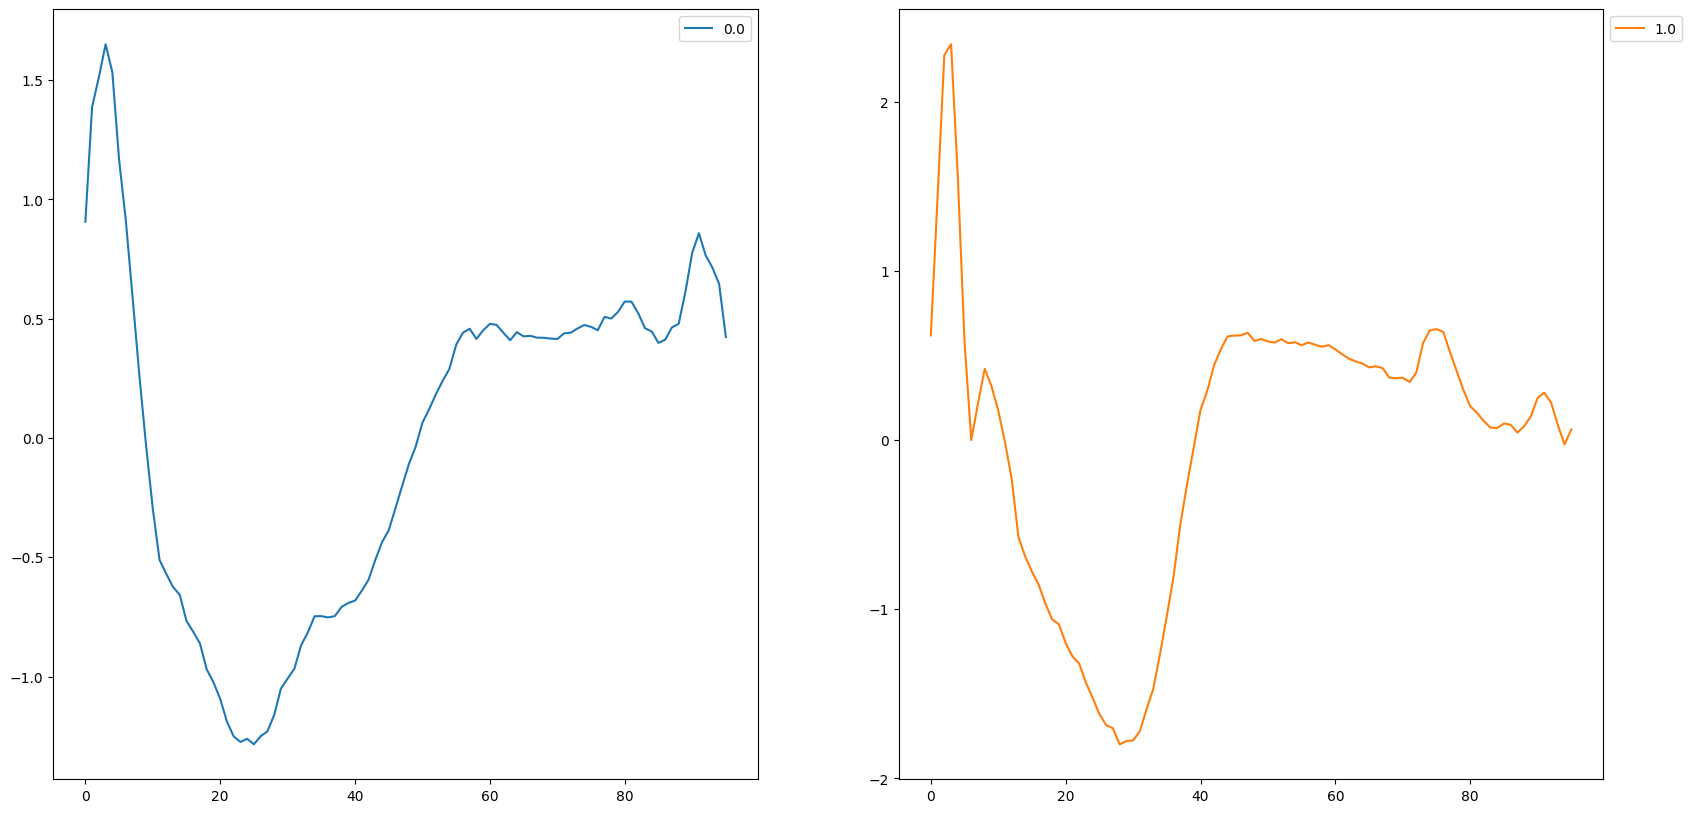

In [15]:
plot_mean_sample(ecg_dataset[0].features,ecg_dataset[0].target)

In [25]:
feature_extractor = pipeline_creator.create_pipeline(recurrence_node_dict)
feature_matrix = feature_extractor.fit(ecg_dataset[0])

In [26]:
n_channels = list(range(feature_matrix.predict.shape[1]))

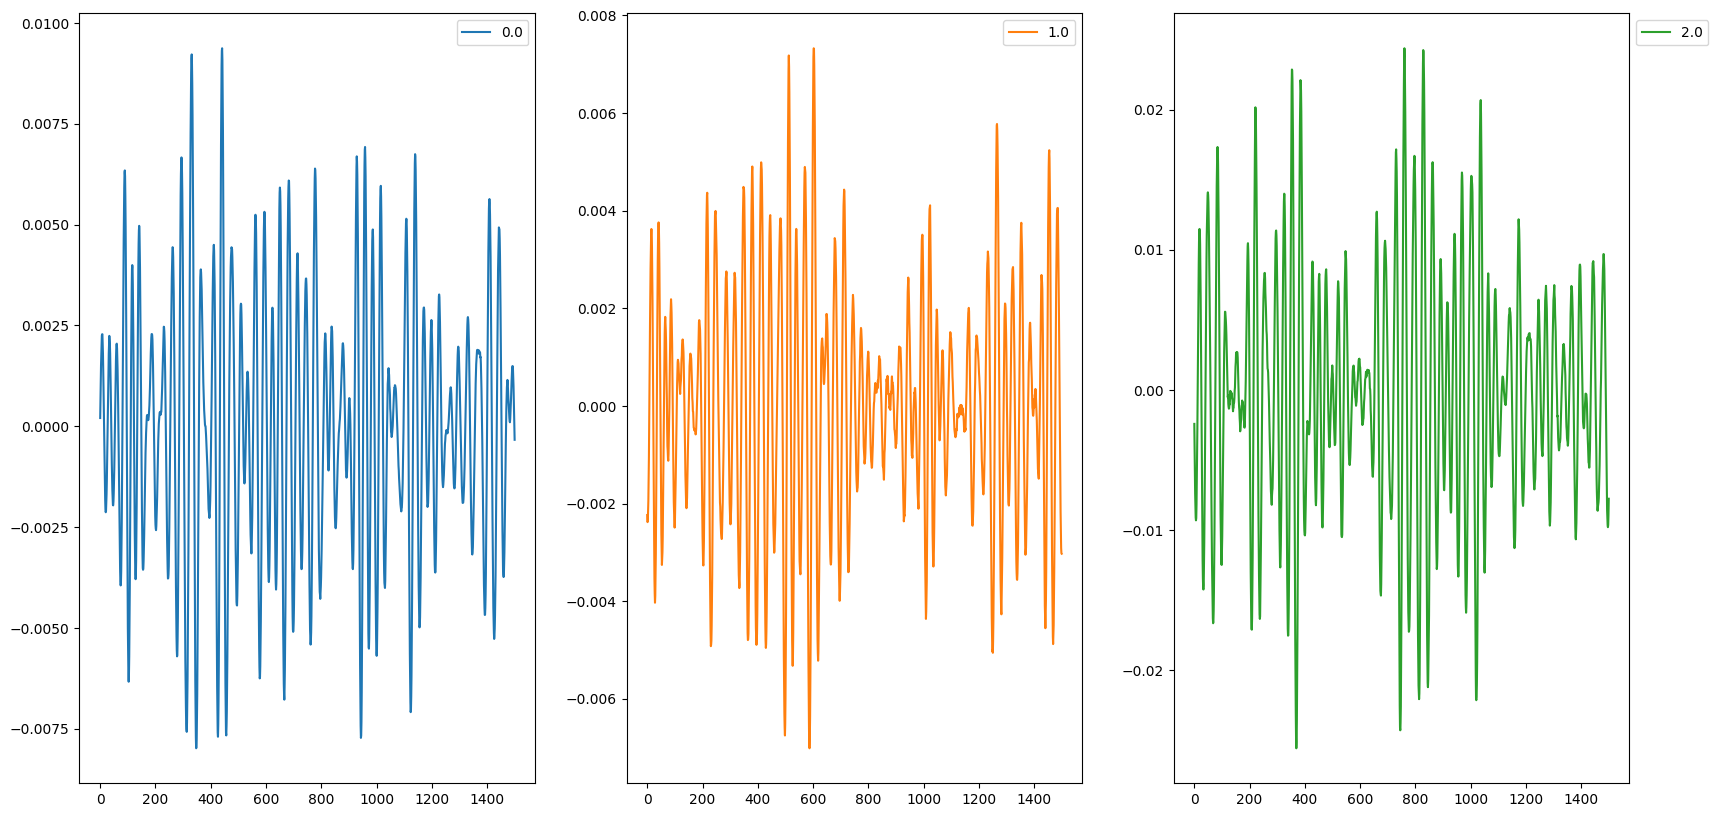

In [27]:
for channel in n_channels:
    y = np.expand_dims(feature_matrix.predict[:,channel,:], axis=1)
    plot_mean_sample(y, feature_matrix.target)

In [265]:
stat_list_model =  {'quantile_extractor':{'window_size':10,
                                             'add_global_features':True,
                                             'use_sliding_window':False},
                       'logit':{}}

In [266]:
result_dict_stat = ApiTemplate(api_config=api_config,
                          metric_list=metric_names).eval(dataset='NerveDamage',
                                                         finetune=finetune,
                                                         initial_assumption = stat_list_model)

2024-10-21 13:13:30,002 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\NerveDamage
2024-10-21 13:13:30,332 - Data read successfully from local folder
2024-10-21 13:13:30,337 - Initialising experiment setup
2024-10-21 13:13:30,368 - -------------------------------------------------
2024-10-21 13:13:30,369 - Initialising Industrial Repository
2024-10-21 13:13:30,370 - -------------------------------------------------
2024-10-21 13:13:30,370 - Initialising Dask Server
Creating Dask Server
2024-10-21 13:13:30,385 - State start
2024-10-21 13:13:30,531 -   Scheduler at: inproc://10.64.4.172/17848/119
2024-10-21 13:13:30,534 -   dashboard at:  http://10.64.4.172:52785/status
2024-10-21 13:13:30,539 - Registering Worker plugin shuffle
2024-10-21 13:13:30,690 -       Start worker at: inproc://10.64.4.172/17848/122
2024-10-21 13:13:30,690 -          Listening to:          inproc10.64.4.172
2024-10-21 13:13:30,691 -           Worker name:                          0
2024-1

In [267]:
result_dict_stat['metrics']

,accuracy,f1,precision
0,1.0,1.0,1.0


In [268]:
fourier_list_model =  {'fourier_basis':{'threshold':threshold,
                                'approximation':approximation,
                              'low_rank':low_rank},
                       'quantile_extractor':{'window_size':10,
                                             'add_global_features':True,
                                             'use_sliding_window':False},
                       'logit':{}}

In [269]:
result_dict_fourier = ApiTemplate(api_config=api_config,
                                    metric_list=metric_names).eval(dataset='NerveDamage',
                                                         finetune=finetune,
                                                         initial_assumption = fourier_list_model)

2024-10-21 13:14:51,008 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\NerveDamage
2024-10-21 13:14:51,336 - Data read successfully from local folder
2024-10-21 13:14:51,341 - Initialising experiment setup
2024-10-21 13:14:51,371 - -------------------------------------------------
2024-10-21 13:14:51,372 - Initialising Industrial Repository
2024-10-21 13:14:51,373 - -------------------------------------------------
2024-10-21 13:14:51,373 - Initialising Dask Server
Creating Dask Server
2024-10-21 13:14:51,385 - State start
2024-10-21 13:14:51,527 -   Scheduler at: inproc://10.64.4.172/17848/127
2024-10-21 13:14:51,528 -   dashboard at:  http://10.64.4.172:52871/status
2024-10-21 13:14:51,529 - Registering Worker plugin shuffle
2024-10-21 13:14:51,667 -       Start worker at: inproc://10.64.4.172/17848/130
2024-10-21 13:14:51,667 -          Listening to:          inproc10.64.4.172
2024-10-21 13:14:51,668 -           Worker name:                          0
2024-1

In [270]:
result_dict_fourier['metrics']

,accuracy,f1,precision
0,0.634,0.639,0.572


In [28]:
wavelet_list_model =  {'wavelet_basis':{'wavelet':wavelet,
                                'n_components':n_components,
                                      'low_freq':low_freq},
                       'quantile_extractor':{'window_size':10,
                                             'add_global_features':True,
                                             'use_sliding_window':False},
                       'logit':{}}

In [ ]:
result_dict_wavelet = ApiTemplate(api_config=api_config,
                                    metric_list=metric_names).eval(dataset='NerveDamage',
                                                         finetune=finetune,
                                                         initial_assumption = wavelet_list_model)

2024-10-21 13:58:21,882 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS\fedot_ind\data\NerveDamage
2024-10-21 13:58:22,100 - Data read successfully from local folder
2024-10-21 13:58:22,103 - Initialising experiment setup
2024-10-21 13:58:22,119 - -------------------------------------------------
2024-10-21 13:58:22,120 - Initialising Industrial Repository
2024-10-21 13:58:22,121 - -------------------------------------------------
2024-10-21 13:58:22,121 - Initialising Dask Server
Creating Dask Server
2024-10-21 13:58:22,127 - State start
2024-10-21 13:58:22,264 -   Scheduler at: inproc://10.64.4.172/24900/9
2024-10-21 13:58:22,265 -   dashboard at:  http://10.64.4.172:55502/status
2024-10-21 13:58:22,265 - Registering Worker plugin shuffle
2024-10-21 13:58:22,405 -       Start worker at: inproc://10.64.4.172/24900/12
2024-10-21 13:58:22,405 -          Listening to:          inproc10.64.4.172
2024-10-21 13:58:22,406 -           Worker name:                          0
2024-10-2

In [ ]:
result_dict_wavelet['metrics']